In [79]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [80]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.sigmoid(self.fc3(x))
        return out

def l1_regularization(model, l1_lambda):
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
    return l1_lambda * l1_loss

def l2_regularization(model, l2_lambda):
    l2_loss = 0
    for param in model.parameters():
        l2_loss += torch.sum(torch.square(param))
    return l2_lambda * l2_loss

def train_model(model, criterion, optimizer, X_train, y_train, l1_lambda, l2_lambda):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1)) + l1_regularization(model, l1_lambda) + l2_regularization(model,l2_lambda)
    loss.backward()
    optimizer.step()
    return loss.item()

def test_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
    return accuracy

def plot(model):
    XX, YY = torch.meshgrid(torch.linspace(-700, 700, 1000), torch.linspace(-800, 800, 1000))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    
    probs = logits.reshape(1000, 1000)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()

    
    plt.scatter(X_train[:, 0].detach().numpy(), X_train[:, 1].detach().numpy(),c=y_train, cmap=plt.cm.Spectral)


Dataset

In [81]:
num_samples = 400
mean, std_dev = 0, 250
np.random.seed(42)

x1 = np.random.normal(mean, std_dev, num_samples)
x2 = np.random.normal(mean, std_dev, num_samples)
data = np.column_stack((x1, x2))
labels = np.where(x1 * x2 > 0, 1, 0)  # Label as 1 if product > 0, otherwise 0

data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(data_tensor, labels_tensor, test_size=0.5, random_state=42)

In [82]:
model_a=MLP(2,8,4,1)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model_a.parameters(), lr=0.01)

# Step 4: Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model_a(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.2214
Epoch [200/1000], Loss: 0.0930
Epoch [300/1000], Loss: 0.0613
Epoch [400/1000], Loss: 0.0426
Epoch [500/1000], Loss: 0.0306
Epoch [600/1000], Loss: 0.0225
Epoch [700/1000], Loss: 0.0172
Epoch [800/1000], Loss: 0.0135
Epoch [900/1000], Loss: 0.0109
Epoch [1000/1000], Loss: 0.0090


In [83]:
with torch.no_grad():
    predicted = model_a(X_test)
    predicted_classes = predicted.round()
    accuracy = (predicted_classes == y_test.view(-1, 1)).sum().item() / len(y_test)
    accuracy = 100*accuracy
    print(f'Test Accuracy: {accuracy:.4f}')
    

Test Accuracy: 100.0000


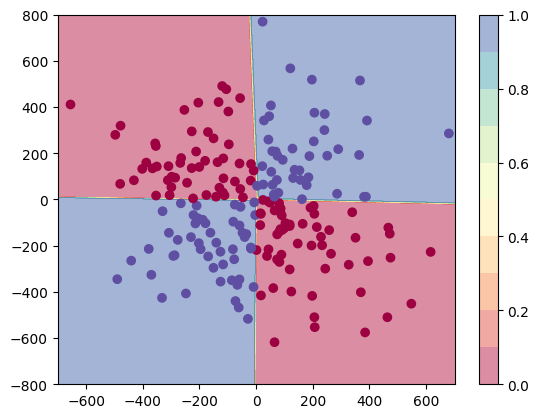

In [100]:
plot(model_a)

MLP w/ L1 regularization

In [85]:
learning_rate = 0.02
num_epochs = 100

lambda_values = np.array(range(5,101,5))
lambda_values = lambda_values/100

best_accuracy = 0
best_lambda_l1 = None
for lambda_ in lambda_values:
    model_l1_lambda = MLP(2, 8, 4, 1)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model_l1_lambda.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=np.random.randint(100))
        
        inputs = X_training
        labels = y_training

        loss = train_model(model_l1_lambda, criterion, optimizer, inputs, labels, lambda_, 0)
        
        accuracy = test_model(model_l1_lambda, X_validation, y_validation)
        print(f"Lambda: {lambda_}, Test accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda_l1 = lambda_

print("Best lambda:", best_lambda_l1)
print("Best accuracy:", best_accuracy)


Lambda: 0.05, Test accuracy: 0.42
Lambda: 0.05, Test accuracy: 0.48
Lambda: 0.05, Test accuracy: 0.44
Lambda: 0.05, Test accuracy: 0.56
Lambda: 0.05, Test accuracy: 0.48
Lambda: 0.05, Test accuracy: 0.58
Lambda: 0.05, Test accuracy: 0.56
Lambda: 0.05, Test accuracy: 0.66
Lambda: 0.05, Test accuracy: 0.72
Lambda: 0.05, Test accuracy: 0.66
Lambda: 0.05, Test accuracy: 0.8
Lambda: 0.05, Test accuracy: 0.64
Lambda: 0.05, Test accuracy: 0.62
Lambda: 0.05, Test accuracy: 0.94
Lambda: 0.05, Test accuracy: 0.94
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test accuracy: 0.94
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test accuracy: 1.0
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test accuracy: 1.0
Lambda: 0.05, Test accuracy: 1.0
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test

In [86]:
model_l1 = MLP(2,8,4,1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_l1.parameters(), lr=learning_rate)
l1_regularization(model_l1,best_lambda_l1)

# best lambda came out to be 0.05
num_epochs = 2000
for epoch in range(num_epochs):
    loss = train_model(model_l1, criterion, optimizer, inputs, labels, best_lambda_l1, 0)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

Epoch [100/2000], Loss: 0.2776
Epoch [200/2000], Loss: 0.2677
Epoch [300/2000], Loss: 0.2654
Epoch [400/2000], Loss: 0.2654
Epoch [500/2000], Loss: 0.2653
Epoch [600/2000], Loss: 0.2653
Epoch [700/2000], Loss: 0.2656
Epoch [800/2000], Loss: 0.2656
Epoch [900/2000], Loss: 0.2651
Epoch [1000/2000], Loss: 0.2664
Epoch [1100/2000], Loss: 0.2653
Epoch [1200/2000], Loss: 0.2653
Epoch [1300/2000], Loss: 0.2657
Epoch [1400/2000], Loss: 0.2651
Epoch [1500/2000], Loss: 0.2652
Epoch [1600/2000], Loss: 0.2646
Epoch [1700/2000], Loss: 0.2661
Epoch [1800/2000], Loss: 0.2660
Epoch [1900/2000], Loss: 0.2660
Epoch [2000/2000], Loss: 0.2653


In [87]:
with torch.no_grad():
    predicted = model_l1(X_test)
    predicted_classes = predicted.round()
    accuracy = (predicted_classes == y_test.view(-1, 1)).sum().item() / len(y_test)
    accuracy = 100*accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 98.0000


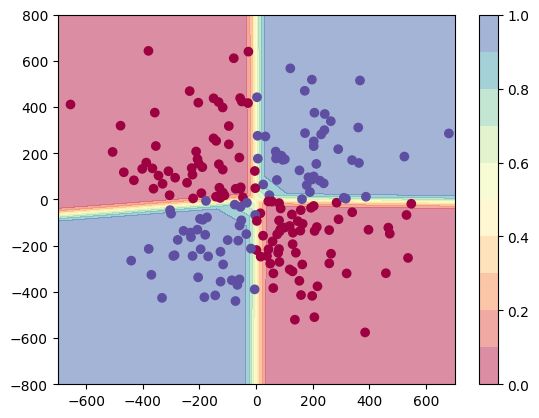

In [88]:
plot(model_l1)

MLP w/ L2 regularization

In [89]:
learning_rate = 0.01
num_epochs = 100

lambda_values = np.array(range(5,101,5))
lambda_values = lambda_values/100

# Train the model with different penalty coefficients
best_accuracy = 0
best_lambda_l2 = None
for lambda_ in lambda_values:
    model_l2_lambda = MLP(2, 8, 4, 1)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model_l2_lambda.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=np.random.randint(100))
        
        inputs = X_training
        labels = y_training

        loss = train_model(model_l2_lambda, criterion, optimizer, inputs, labels, 0, lambda_)
        
        accuracy = evaluate_model(model_l2_lambda, X_validation, y_validation)
        print(f"Lambda: {lambda_}, Test accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda_l2 = lambda_

print("Best lambda:", best_lambda_l2)
print("Best accuracy:", best_accuracy)


Lambda: 0.05, Test accuracy: 0.64
Lambda: 0.05, Test accuracy: 0.56
Lambda: 0.05, Test accuracy: 0.56
Lambda: 0.05, Test accuracy: 0.6
Lambda: 0.05, Test accuracy: 0.62
Lambda: 0.05, Test accuracy: 0.66
Lambda: 0.05, Test accuracy: 0.76
Lambda: 0.05, Test accuracy: 0.74
Lambda: 0.05, Test accuracy: 0.72
Lambda: 0.05, Test accuracy: 0.88
Lambda: 0.05, Test accuracy: 0.88
Lambda: 0.05, Test accuracy: 0.86
Lambda: 0.05, Test accuracy: 0.76
Lambda: 0.05, Test accuracy: 0.76
Lambda: 0.05, Test accuracy: 0.78
Lambda: 0.05, Test accuracy: 0.8
Lambda: 0.05, Test accuracy: 0.9
Lambda: 0.05, Test accuracy: 0.9
Lambda: 0.05, Test accuracy: 0.92
Lambda: 0.05, Test accuracy: 0.88
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test accuracy: 0.9
Lambda: 0.05, Test accuracy: 0.9
Lambda: 0.05, Test accuracy: 0.92
Lambda: 0.05, Test accuracy: 0.94
Lambda: 0.05, Test accuracy: 0.9
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test accuracy: 0.88
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test ac

In [90]:
model_l2 = MLP(2,8,4,1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_l2.parameters(), lr=learning_rate)


num_epochs = 1000
for epoch in range(num_epochs):
    loss = train_model(model_l2, criterion, optimizer, inputs, labels, 0, best_lambda_l2)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

Epoch [100/1000], Loss: 0.4003
Epoch [200/1000], Loss: 0.3228
Epoch [300/1000], Loss: 0.3070
Epoch [400/1000], Loss: 0.3005
Epoch [500/1000], Loss: 0.2957
Epoch [600/1000], Loss: 0.2885
Epoch [700/1000], Loss: 0.2855
Epoch [800/1000], Loss: 0.2841
Epoch [900/1000], Loss: 0.2831
Epoch [1000/1000], Loss: 0.2822


In [91]:
with torch.no_grad():
    predicted = model_l2(X_test)
    predicted_classes = predicted.round()
    accuracy = (predicted_classes == y_test.view(-1, 1)).sum().item() / len(y_test)
    accuracy = 100*accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 97.5000


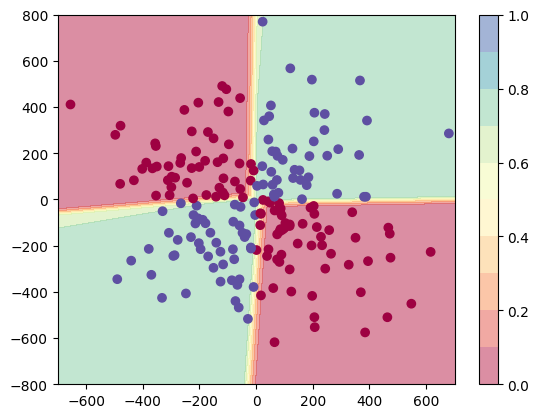

In [103]:
plot(model_l2)

In [93]:
x3_array = np.array(x1_array*x2_array)
x4_array = np.array(np.square(x1_array))
x5_array = np.array(np.square(x2_array))
Dataset_array = np.column_stack((x1_array,x2_array,x3_array,x4_array,x5_array))

x1 = torch.tensor(x1_array, dtype=torch.float32)
x2 = torch.tensor(x2_array, dtype=torch.float32)
x3 = torch.tensor(x3_array, dtype=torch.float32)
x4 = torch.tensor(x4_array, dtype=torch.float32)
x5 = torch.tensor(x5_array, dtype=torch.float32)

X_train_array = np.array(Dataset[:200,:])
y_train_array = np.where((X_train_array[:,0]*X_train_array[:,1])>0,1,0)

X_test_array = np.array(Dataset[200:,:])
y_test_array = np.where((X_test_array[:,0]*X_test_array[:,1])>0,1,0)

X_train = torch.tensor(X_train_array, dtype=torch.float32)
y_train = torch.tensor(y_train_array, dtype=torch.float32)

X_test = torch.tensor(X_test_array, dtype=torch.float32)
y_test = torch.tensor(y_test_array, dtype=torch.float32)

Dataset = torch.tensor(Dataset_array, dtype = torch.float32)

In [94]:
#features used are x1 x2 only
X = np.column_stack((x1,x2))
X_train_1 = X[:200,:] 
X_test_1 = X[200:,:]
model_logistic_1 = LogisticRegression(penalty='none')
model_logistic_1.fit(X_train_1,y_train)

LogisticRegression(penalty='none')

In [95]:
predicted_labels = model_logistic_1.predict(X_test_1)
true_labels = y_test
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy*100)

Accuracy: 56.00000000000001


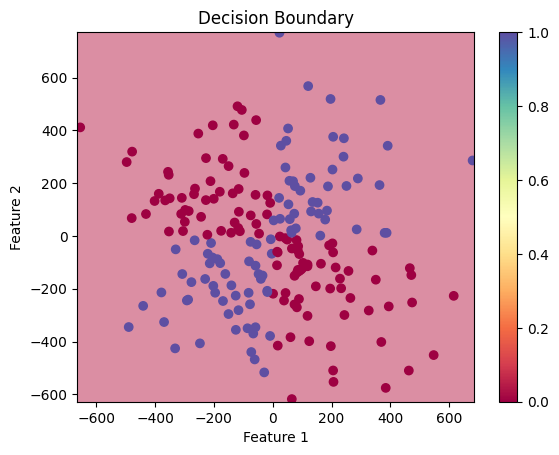

In [96]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
    y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
    h = 10  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xx1 = np.square(xx)
    xx2 = np.square(yy)
    xx3 = np.multiply(xx,yy)

    # Predict the function value for the whole grid
    Z = model.predict(np.column_stack([xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.colorbar()
    plt.show()

# Example usage:
plot_decision_boundary(model_logistic_1, X_train_1, y_train)

In [97]:
#features used is x1.x2 only
X = x3
X_train_2 = X[:200] 
X_test_2 = X[200:]
model_logistic_2 = LogisticRegression(penalty='none')
model_logistic_2.fit(X_train_2.reshape(-1, 1),y_train)

LogisticRegression(penalty='none')

In [98]:
predicted_labels = model_logistic_2.predict(X_test_2.reshape(-1, 1))
true_labels = y_test

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy*100)

Accuracy: 100.0


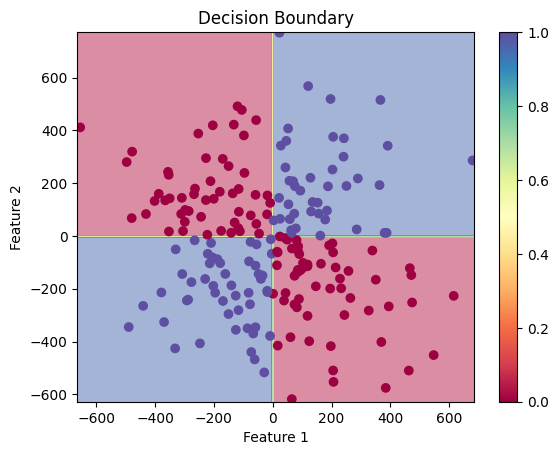

In [106]:
plot_decision_boundary(model_logistic_2, X_train_1, y_train)

In [107]:
X = np.column_stack((x1,x2,x4,x5))
X_train_3 = X[:200,:] 
X_test_3 = X[200:,:]
model_logistic_3 = LogisticRegression(penalty='none')
model_logistic_3.fit(X_train_3,y_train)

LogisticRegression(penalty='none')

In [108]:
predicted_labels = model_logistic_3.predict(X_test_3)
true_labels = y_test

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy*100)

Accuracy: 55.00000000000001


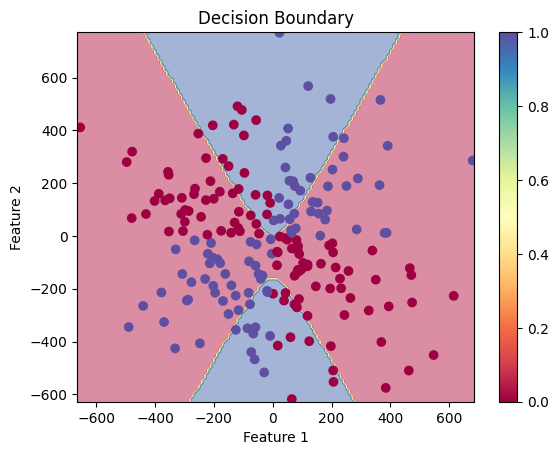

In [112]:
plot_decision_boundary(model_logistic_3, X_train_3, y_train)